## Global rates of soil production independent of soil depth
E.J. Harrison

ejharris@ucsd.edu

This is a companion notebook to a manuscript submitted to *Science*. In this manuscript, we compare soil production rates measured in study areas that are geologically and climatically stable with soil production rates measured in landscapes that adjust to maintain dynamic equilibrium with a changing baselevel. We find that soil production rates increase exponentially with decreasing soil depth only in active landscapes, and that in stable settings soil production is depth-invariant. 

In this jupyter notebook we present the companion model to this analysis, which demonstrates that an exponential depth-dependence can be erroneously predicted from the method of measuring the [10Be] concentrations of samples collected at depth. The notebook it divided into three parts.

**Part 1:** A model hillslope is created in which the soil mantle covering the slope increases slightly with distance from the drainage divide.

**Part 2:** The modeled soil mantle is eroded by different amounts incrementally. The amount of erosion is related linearly to the slope at points along the curved line representing the hillslope surface. Multiple coefficients for this linear relationship are tested.

**Part 3:** An exponential regression is run on each array of values representing the soil thickness and the soil production rate for each of the modeled scenarios.

**Part 4:** The exponential equations best fitting each model run are visualized and compared with the published datasets.

Python 3.7.4

Import the modules used in this notebook

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from scipy.optimize import curve_fit
from matplotlib import rcParams
from mpl_toolkits.axes_grid1 import make_axes_locatable
from mpl_toolkits.axes_grid1.colorbar import colorbar
import matplotlib as mpl
import matplotlib.ticker as mtick
from matplotlib.ticker import (MultipleLocator, FormatStrFormatter,
                               AutoMinorLocator)

Define the functions used in this notebook

In [2]:
def explode(df, lst_cols, fill_value='', preserve_index=False):
    """Split (explode) pandas dataframe string entry to separate rows.
    
    Parameters
    ----------
    df : 
    lst_cols :
    fill_value : (optional)
    preserve_index : (optional)
    
    Returns
    --------
    df :
    
    Function copied from : 
    https://stackoverflow.com/questions/12680754/split-explode-pandas-dataframe-string-entry-to-separate-rows/40449726#40449726
    
    """
    # make sure `lst_cols` is list-alike
    if (lst_cols is not None
        and len(lst_cols) > 0
        and not isinstance(lst_cols, (list, tuple, np.ndarray, pd.Series))):
        lst_cols = [lst_cols]
    # all columns except `lst_cols`
    idx_cols = df.columns.difference(lst_cols)
    # calculate lengths of lists
    lens = df[lst_cols[0]].str.len()
    # preserve original index values    
    idx = np.repeat(df.index.values, lens)
    # create "exploded" DF
    res = (pd.DataFrame({
                col:np.repeat(df[col].values, lens)
                for col in idx_cols},
                index=idx)
             .assign(**{col:np.concatenate(df.loc[lens>0, col].values)
                            for col in lst_cols}))
    # append those rows that have empty lists
    if (lens == 0).any():
        # at least one list in cells is empty
        res = (res.append(df.loc[lens==0, idx_cols], sort=False)
                  .fillna(fill_value))
    # revert the original index order
    res = res.sort_index()
    # reset index if requested
    if not preserve_index:        
        res = res.reset_index(drop=True)
    return res

In [3]:
def exponential_fit(x, a, k):
    """Calculate exponential change in *x*
    
    Parameters
    ----------
    x : float ndarray
        The x-values.
    a : float or 1-element float ndarray
        The inital value of the function.
    k : float or 1-element float ndarray
        The rate of growth.
    
    Returns
    -------
    float ndarray
        The fitted y-values.
    
    """
    return a* np.exp(-k *x)

## PART I
### Creating a model hillslope

Here, the function of a parabola is defined:

In [4]:
def f(x):
    return x**2 +6*x

Generate two depth surfaces representing the subaerial and soil-saprolite surfaces

In [5]:
x = np.linspace(0,20,20) # create an evenly spaced value array between 0,50
sap_soil = (f(x)+100) # value array representing soil-saprolite interface
const_soil = f(x) # value array representing subaerial soil surface of constant thickness

A second parabolic function with more steeply graded curature is defined here:

In [6]:
def f(c):
    return c**2 +2*c

And a surface representing the second parabola is generated.

In [7]:
c = np.linspace(0,20,20)
curv_soil = (f(c))

The slope of the parabolic function (c) is calculated for 20 points along the curve:

In [8]:
# define list of points
up = abs(curv_soil) # absolute value of "elevations"
over = x * 100 # match vertical exaggeration in display plot

# list iteration to generate a list of slope values
rise = [j-i for i, j in zip(up[:-1], up[1:])] # change in y 
run = [j-i for i, j in zip(over[:-1], over[1:])] # change in x
slope = [(i/j)*100 for i, j in zip(rise, run)]
slope = [abs(number) for number in slope]
slope.insert(0,0) # insert 0 for the first point
slope = [round(num, 0) for num in slope] # round list

The surfaces are plotted together to visualize the model hillslope.

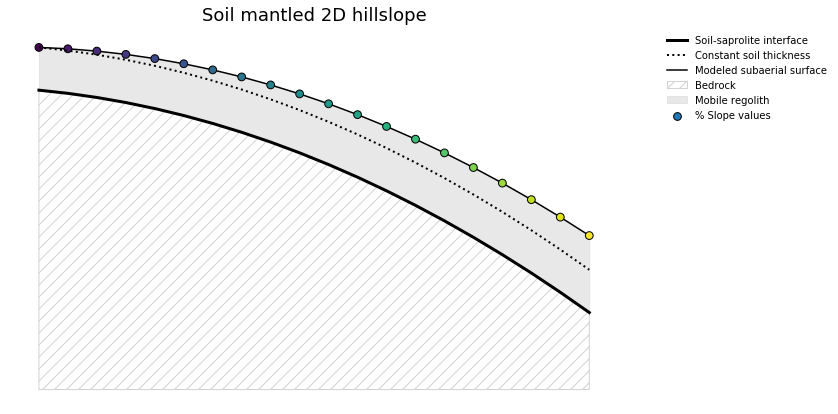

In [9]:
fig, ax = plt.subplots(figsize=(11,7))

# Visualize the surfaces -------------------------------------------------
ax.plot(x, sap_soil, color='k', linewidth=3, label='Soil-saprolite interface') # soil-saprolite interface
ax.fill_between(x, 800, sap_soil, facecolor='white', hatch='//', edgecolor='lightgrey', label='Bedrock') # color in bedrock

# constant thickness surface for visualization
ax.plot(x, const_soil, color='k', linewidth=2, linestyle=':', label='Constant soil thickness') 

ax.plot(x, curv_soil, color='k', label='Modeled subaerial surface', zorder=1) # subaerial soil surface 
ax.fill_between(x, sap_soil, curv_soil, alpha=0.5, color='lightgrey', label='Mobile regolith') # color in soil

# slope values
ax.scatter(x, curv_soil, c=slope, s=60, edgecolor='k', zorder=2, label='% Slope values')

ax.invert_yaxis()
ax.set_axis_off()
ax.legend(frameon=False, bbox_to_anchor=(1.35, 1), loc='upper right')
ax.set_title('Soil mantled 2D hillslope', fontsize=18)
plt.show()

A dataframe is generated to store the values.

In [10]:
depth2sap = pd.DataFrame() # initialize df 
depth2sap['depth'] = abs(curv_soil-sap_soil) # compute regolith thickness
depth2sap = depth2sap.round(decimals=0) # round to whole numbers
depth2sap['slope'] = slope

Calculate a $^{10}$Be production rate for each depth interval, using **equation 1**:

### $P_z = P_o e^{-z\rho / \Lambda}$

#### Variables in arrays: 

$P_o$ = Surface production rate = 5 [atoms g-1 yr-1]

$\rho$ = Soil density = 1.4 [g cm-3]

#### Constant:

$\Lambda$ = Attenuation length = 165 [g cm-1]

In [11]:
def p_rate(i):
    return 5 * np.exp(-i*1.4/165)

$^{10}$Be production rate is calculated using the function "p_rate" and stored as a column in the dataframe "depth2sap":

In [12]:
depth2sap['p_rate'] = depth2sap['depth'].apply(p_rate)

Calculate the nuclide concentration at depth $z$ from **equation 2**:
### $C_z = P_z  \left( \frac{1}{\lambda + \frac{\rho \in}{\Lambda}} \right)$

#### Constants:

$\lambda$ = $^{10}$Be decay constant = approximated as 0 for this simulation

$\in$ = Erosion rate = 40 [cm yr-1] for this simulation

In [13]:
def c_z(p):
    return p/((1.4*4)/165)

$^{10}$Be concentration is calculated using the function "c_z" and stored as a column in the dataframe "depth2sap":

In [14]:
depth2sap['[be]'] = c_z(depth2sap['p_rate'])

The steady-state $^{10}$Be concentration is stored as a variable.

In [15]:
ss_10be = depth2sap['[be]']

Calculate the apparent erosion rate from $C_z$ using **equation 3**:

### $E_z = \left( \frac {\Lambda}{\rho} \right) \left( \frac{P_z}{C_z} \right)$

In [16]:
def e_z(p):
    return (165/1.4) * (p/ss_10be)

Soil production rate is calculated using the function "e_z" and stored as a column in the dataframe "depth2sap":

In [17]:
depth2sap['e_rate'] = e_z(depth2sap['p_rate'])
depth2sap['e_rate'] = depth2sap['e_rate'].astype(float).round(2) # define the data type and round decimals

Hillslope is in steady-state, erosion rate is constant everywhere. Visualize the df:

In [18]:
depth2sap

,depth,slope,p_rate,[be],e_rate
0,100.0,0.0,2.140315,63.062856,4.0
1,104.0,3.0,2.068893,60.958454,4.0
2,108.0,5.0,1.999854,58.924275,4.0
3,113.0,7.0,1.916786,56.476742,4.0
4,117.0,9.0,1.852823,54.592118,4.0
5,121.0,11.0,1.790995,52.770384,4.0
6,125.0,14.0,1.731230,51.009441,4.0
7,129.0,16.0,1.673459,49.307260,4.0
8,134.0,18.0,1.603948,47.259188,4.0
9,138.0,20.0,1.550425,45.682153,4.0


## PART II
### Calculating the effect of changing soil thickness

Here, coefficients for slope-dependence of sediment flux are stored in a list

In [20]:
# reference coefficient from McKean et al. (1993) is 360
Qs_coef = np.linspace(400, 210, 100).astype(int)

Change in the depth to saprolite is calculated from a linear relationship between a coefficient and the slope.

In [21]:
sed_out = [] # initialize an empty list

for coef in Qs_coef:
    sdata = np.array(depth2sap['slope']*0.01) # store slope values in list
    sed_out.append(coef * sdata) # linear function of flux coefficient and slope
    
    e_run = pd.DataFrame() # temporary dataframe
    e_run['sed_out'] = sed_out # append slope-dependent transport values

e_run = e_run.T.reset_index(drop=True) # transpose rows to colums
e_run.columns = Qs_coef # assign column names from coefficient list
e_run = e_run.add_prefix('Qs_') 

Define a function that will be used below:

Here, the column names are stored as a list.

In [22]:
col_list = e_run.columns.to_list()

The dataframe content is expanded into unique rows.

In [23]:
sed_flux = explode(e_run, lst_cols=col_list)

Values representing sediment flux are subtracted from the original depth values and stored in a new df.

In [24]:
new_depth =  sed_flux.rsub(depth2sap['depth'], axis=0) # subtract sed_flux from original depths
new_depth[new_depth < 0] = 0 # replace negative values with 0
new_depth = new_depth.round(0)

The function for determining $^{10}$Be production rates at a given depth are determined for every cell and stored in a new df.

In [25]:
new_prate = new_depth.applymap(p_rate) 

The function for calculating erosion is applied to the modeled data and an apparent soil production rate for each element is stored in a new dataframe. The concentrations of $^{10}$Be used in this calculation are derived from the steady-state condition. 

In [26]:
soil_prod = new_prate.apply(e_z).round(0)
soil_prod = soil_prod.add_suffix('_rates')

## PART III
### Fitting the modeled data

Define the exponential regression function to be called.

Data frames containing the modeled depths and soil production rate values are joined into a singe data frame.

In [27]:
dfs = [new_depth, soil_prod]
modeled_scenarios = pd.concat(dfs, axis=1, join='inner')

Curve fitting is used to determine the coefficients of an exponential regression to the modeled data:

In [28]:
result = [] # initialize lists
label = []

for depths in new_depth.columns:
    xdata = new_depth[depths] # loop through depths
    ydata = soil_prod.loc[:,soil_prod.columns.str.startswith(depths)].squeeze() 
    # soil production rates corresponding to the depth array
        
    popt, pcov = curve_fit(exponential_fit, xdata, ydata, p0=(100, 0.01))
    # find parameters for the exponential regression 
    
    result.append(popt) # store results
    label.append(depths) # store labels

Store the fit parameters in a dictionary.

In [29]:
spf_dict = dict(zip(label, result))

Add the steady-state scenario to the dictionary:

Plot the Qs coefficient values against the best-fit exponent of the resulting model.

In [30]:
exp_val = [elem[1] for elem in spf_dict.values()]
coef_val = list(spf_dict.keys())

In [31]:
data = zip(Qs_coef, exp_val)
save_df = pd.DataFrame(data=data, columns=['Qs_coef', 'exp_val'])
save_df.to_csv('exp_list')

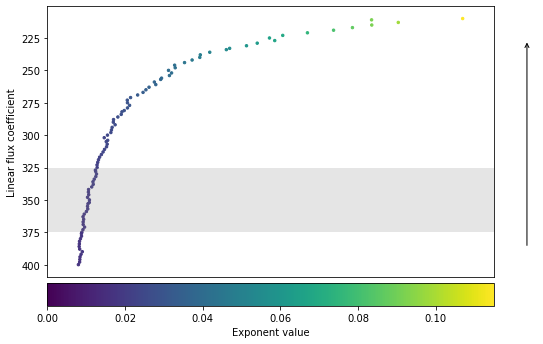

In [36]:
colormap = plt.get_cmap('hsv')
vmax = max(exp_val)

fig, ax = plt.subplots(figsize=(8,6))

ss = ax.scatter(exp_val, Qs_coef, s=6, c=exp_val, vmin=0, vmax=vmax)
ax.axhspan(375, 325, alpha=0.2, fc='gray', ec='none')

ax.invert_yaxis()
ax.set_ylabel('Linear flux coefficient')
ax.set_xticks([])

# Colorbar  -------------------------------------------------------------------------------
fig.colorbar(ss, orientation='horizontal', pad=0.02, 
              label='Exponent value')

# Arrow  ----------------------------------------------------------------------------------
ax.annotate("",
            xy=(0.97, 0.28), xycoords='figure fraction',
            xytext=(0.97, 0.88), textcoords='figure fraction',
            arrowprops=dict(arrowstyle="<-",
                            connectionstyle="arc3"),
            )

plt.show()

## PART IV
### Visualize the model results and compare to published studies

Generate a dictionary that stores some coefficients of fit from the published literature:

In [37]:
published_dict = ({'NZ': [1815, 0.058],
                  'TV': [86.14, 0.024],
                  'SG': [160.77, 0.033],
                  'SK': [40.39, 0.00077],
                  'SA': [5.530480, 0.001136],
                  'CA': [84.58, 0.017],
                  'OR': [157.35, 0.01]})

In [38]:
ss_coef, ss_pcov = curve_fit(exponential_fit, depth2sap['depth'], depth2sap['e_rate'], p0=(100, 0.01))
spf_dict.update({'ss': ss_coef})

An array representing theoretical soil depths is generated for the plot:

In [39]:
x_axis = np.linspace(0, 80, num=20)

Define a function for controlling the plot tick style:

In [40]:
def ticks(y, pos):
    return r'$e^{:.0f}$'.format(np.log(y))

Call on the values stored in the dictionary "spf_dict" to plot the soil production function of each modeled scenario:

In [41]:
def match_color(exponent):
    cmap = mpl.cm.get_cmap('viridis')
    norm = mpl.colors.Normalize(vmin=0, vmax=vmax)
    rgba = cmap(norm(exponent))
    
    return rgba

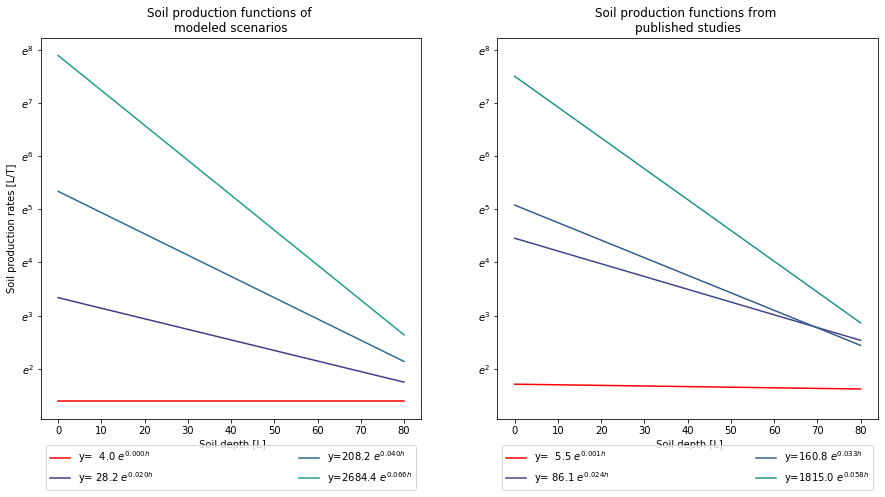

In [46]:
fig, (ax, ax1) = plt.subplots(1,2, figsize=(15,7), sharey=True)

# Visualize the soil production functions -------------------------------------------------

# steady-state 
ax.plot(x_axis, exponential_fit(x_axis, *spf_dict['ss']), color = 'r', 
        label='y=%5.1f $e^{%5.3f h}$' %tuple(spf_dict['ss']))

#Qs coefficient = 350
ax.plot(x_axis, exponential_fit(x_axis, *spf_dict['Qs_350']), color = match_color(spf_dict['Qs_350'][1]), 
        label='y=%5.1f $e^{%5.3f h}$' %tuple(spf_dict['Qs_350']))

# Qs coefficient = 250
ax.plot(x_axis, exponential_fit(x_axis, *spf_dict['Qs_250']), color = match_color(spf_dict['Qs_250'][1]), 
        label='y=%5.1f $e^{%5.3f h}$' %tuple(spf_dict['Qs_250']))

# Qs coefficient = 225
ax.plot(x_axis, exponential_fit(x_axis, *spf_dict['Qs_225']), color = match_color(spf_dict['Qs_225'][1]), 
        label='y=%5.1f $e^{%5.3f h}$' %tuple(spf_dict['Qs_225']))

# Compare to published soil production functions -------------------------------------------------

# Kruger Nat. Park, South Africa
ax1.plot(x_axis, exponential_fit(x_axis, *published_dict['SA']), color='r', 
        label='y=%5.1f $e^{%5.3f h}$' %tuple(published_dict['SA']))

# Tennessee Valley, CA, USA
ax1.plot(x_axis, exponential_fit(x_axis, *published_dict['TV']), color = match_color(published_dict['TV'][1]), 
        label='y=%5.1f $e^{%5.3f h}$' %tuple(published_dict['TV']))

# San Gabriels, CA, USA
ax1.plot(x_axis, exponential_fit(x_axis, *published_dict['SG']), color = match_color(published_dict['SG'][1]), 
        label='y=%5.1f $e^{%5.3f h}$' %tuple(published_dict['SG']))

# Southern Alips, New Zealand
ax1.plot(x_axis, exponential_fit(x_axis, *published_dict['NZ']), color = match_color(published_dict['NZ'][1]), 
        label='y=%5.1f $e^{%5.3f h}$' %tuple(published_dict['NZ']))


# Plot parameters -------------------------------------------------------------------------------
# Left
ax.semilogy(basey=np.e)   # y to log scale
ax.yaxis.set_major_formatter(mtick.FuncFormatter(ticks)) # e^
ax.legend(bbox_to_anchor=(0., -0.2, 1., 1.), loc='lower left',
           ncol=2, mode="expand", borderaxespad=0.5)
ax.set_ylabel('Soil production rates [L/T]')
ax.set_xlabel(' Soil depth [L]')
ax.set_title('Soil production functions of \nmodeled scenarios')

# Right
ax1.semilogy(basey=np.e)   
ax1.yaxis.set_major_formatter(mtick.FuncFormatter(ticks))
ax1.yaxis.set_tick_params(labelleft=True)
ax1.legend(bbox_to_anchor=(0., -0.2, 1., 1.), loc='lower left',
           ncol=2, mode="expand", borderaxespad=0.5)
ax1.set_xlabel(' Soil depth [L]')
ax1.set_title('Soil production functions from \npublished studies')

plt.show()

Here, arrays of the eroded surfaces are generated for the visualization:

In [ ]:
surf350 = sap_soil - new_depth.iloc[:,0]
surf250 = sap_soil - new_depth.iloc[:,1]
surf225 = sap_soil - new_depth.iloc[:,2]
surf100 = sap_soil - new_depth.iloc[:,3]

The changing soil surface and the apparent soil production rates calculated for each are visualized:

In [ ]:
# Set plot parameters -------------------------------------------------
rcParams['image.cmap'] = 'viridis'
rcParams['font.size'] = 14
rcParams['lines.linewidth'] = 0.75

fig, ax = plt.subplots(figsize=(11,7))

# Visualize the UNERODED subaerial surface and saprolite -------------------------------------------------
ax.plot(x, sap_soil, color='k', linewidth=3, label='Soil-saprolite interface') # soil-saprolite interface
ax.fill_between(x, 800, sap_soil, facecolor='white', hatch='//', edgecolor='lightgrey', label='Bedrock') # color in bedrock
ax.plot(x, curv_soil, color='k', linestyle=':', label='Modeled subaerial surfaces', zorder=1) # subaerial soil surface 
ax.fill_between(x, sap_soil, curv_soil, alpha=0.5, color='lightgrey', label='Mobile regolith') # color in soil

# Visualize the modeled erosional surfaces -------------------------------------------------
ax.plot(x, surf350, color='k', label='', zorder=1) 
ax.plot(x, surf225, color='k', label='', zorder=1) 
ax.plot(x, surf100, color='k', label='', zorder=1) 

# Visualize the modeled soil production rates -------------------------------------------------
ss = ax.scatter(x, curv_soil, c=depth2sap['e_rate'], s=50, zorder=2, label = 'Modeled soil production rates')
ax.scatter(x, surf350, c=soil_prod['Qs_350_rates'], s=40, zorder=2)
ax.scatter(x, surf225, c=soil_prod['Qs_225_rates'], s=40, zorder=2)
ax.scatter(x, surf100, c=soil_prod['Qs_100_rates'], s=40, zorder=2)

# Plot parameters -------------------------------------------------------------------------------

ax.invert_yaxis()
ax.set_axis_off()
ax.legend(frameon=False, bbox_to_anchor=(1.35, 1), loc='upper right')
ax.set_title('Modeled Erosion Scenarios', fontsize=18)

# Colorbar  -------------------------------------------------------------------------------
fig.colorbar(ss, orientation='horizontal', pad=0., shrink=0.9, 
             ticks= [], label='Apparent soil production rate [L/T]')

plt.show()